In [8]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset
from flwr import simulation

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
disable_progress_bar()

Training on cpu using PyTorch 2.1.2 and Flower 1.6.0


In [16]:
NUM_CLIENTS = 2  
BATCH_SIZE = 32

In [17]:
def load_datasets():
    
	fds = FederatedDataset(dataset="cifar10", partitioners={'train':NUM_CLIENTS})
	def apply_transform(batch):
		transform = transforms.Compose(
			[
				transforms.ToTensor(),
				transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
			]
		)
		batch["img"] = [transform(img) for img in batch["img"]]
		return batch
	
	trainloaders = []
	valloaders = []
	
	for partition_id in range(NUM_CLIENTS):
		partition = fds.load_partition(partition_id, "train")
		partition = partition.with_transform(apply_transform)
		partition = partition.train_test_split(train_size = 0.8)
		trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
		valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))
	
	testset = fds.load_full("test").with_transform(apply_transform)
	testloader = DataLoader(testset, batch_size=BATCH_SIZE)
	return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

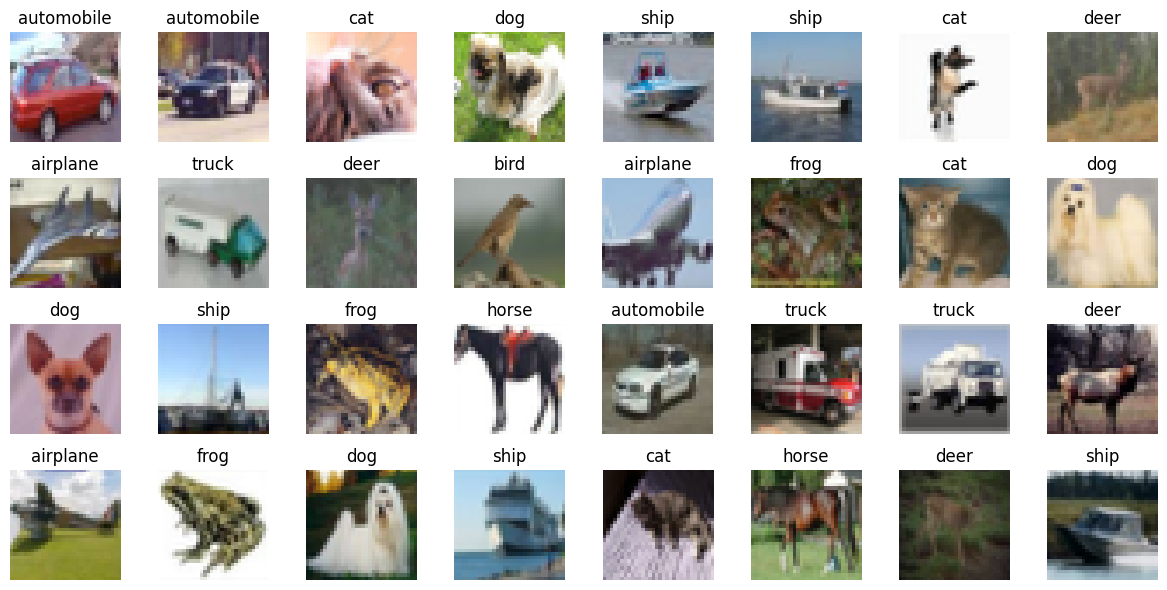

In [4]:
batch = next(iter(trainloaders[0]))
images, labels = batch["img"], batch["label"]
# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloaders[0].dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

##### Define the model

In [9]:
class Net(nn.Module):
	def __init__(self) -> None:
		super(Net, self).__init__()
		self.conv1 = nn.Conv2d(3, 6, 5)
		self.pool = nn.MaxPool2d(2, 2)
		self.conv2 = nn.Conv2d(6, 16, 5)
		self.fc1 = nn.Linear(16*5*5, 120)
		self.fc2 = nn.Linear(120, 84)
		self.fc3 = nn.Linear(84, 10)

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = x.view(-1, 16*5*5)
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x

Training Function

In [33]:
def train(net, trainloader, epochs:int):
	criterion = torch.nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(net.parameters())
	net.train()
	for epoch in range(epochs):
		correct, total, epoch_loss = 0, 0, 0.0
		for batch in trainloader:
			images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
			optimizer.zero_grad()
			outputs = net(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			# Metrics
			epoch_loss += loss
			total += labels.size(0)
			correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
		epoch_loss /= len(trainloader.dataset)
		epoch_acc = correct / total
		print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

Test Function

In [13]:
def test(net, testloader):
	criterion = torch.nn.CrossEntropyLoss()
	correct, total, loss = 0,0,0.0
	net.eval()
	with torch.no_grad():
		for batch in testloader:
			images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
			outputs = net(images)
			loss += criterion(outputs, labels).item()
			_, predicted = torch.max(outputs.data, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
	loss /= len(testloader.dataset)
	accuracy = correct / total
	return loss, accuracy

Training the model (Centralized Learning)

In [43]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(10):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: train loss 0.056466709822416306, accuracy 0.3354
Epoch 1: validation loss 0.051104464554786684, accuracy 0.4062
Epoch 1: train loss 0.047168973833322525, accuracy 0.4534
Epoch 2: validation loss 0.04690022430419922, accuracy 0.4752
Epoch 1: train loss 0.04312144219875336, accuracy 0.5046
Epoch 3: validation loss 0.04391749147176743, accuracy 0.502
Epoch 1: train loss 0.040121350437402725, accuracy 0.54315
Epoch 4: validation loss 0.04180620174407959, accuracy 0.5288
Epoch 1: train loss 0.03779216855764389, accuracy 0.56915
Epoch 5: validation loss 0.04064356963634491, accuracy 0.547
Epoch 1: train loss 0.03596760705113411, accuracy 0.58975
Epoch 6: validation loss 0.04019869821071625, accuracy 0.5526
Epoch 1: train loss 0.03424385190010071, accuracy 0.60895
Epoch 7: validation loss 0.03981279392242432, accuracy 0.5592
Epoch 1: train loss 0.03265302628278732, accuracy 0.6301
Epoch 8: validation loss 0.03966708533763885, accuracy 0.5622
Epoch 1: train loss 0.0310744009912014, ac

Federated Learning

In [35]:
def get_parameters(net)->List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k,v in params_dict})
    net.load_state_dict(state_dict, strict = True)    

Implementing Flower Client

In [36]:
class FlwrClient(fl.client.NumPyClient):
	def __init__(self, net, trainloader, valloader):
		self.net = net
		self.trainloader = trainloader
		self.valloader = valloader
	
	def get_parameters(self):
		return get_parameters(self.net)

	def fit(self, parameters, config):
		set_parameters(self.net, parameters)
		train(self.net, self.trainloader, epochs=1)
		return get_parameters(self.net), len(self.trainloader), {}
	
	def evaluate(self, parameters, config):
		set_parameters(self.net, parameters)
		loss, accuracy = test(self.net, self.valloader)
		return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [37]:
def client_fn(cid: str) -> FlwrClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlwrClient(net, trainloader, valloader).to_client()

In [38]:
def client_fn(cid: str) -> FlwrClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlwrClient(net, trainloader, valloader).to_client()

In [ ]:
load_datasets("")

In [39]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=2,  # Never sample less than 10 clients for training
    min_evaluate_clients=2,  # Never sample less than 5 clients for evaluation
    min_available_clients=2,  # Wait until all 10 clients are available
)

# Specify the resources each of your clients need. By default, each 
# client will be allocated 1x CPU and 0x CPUs
client_resources = {"num_cpus": 8, "num_gpus": 0.0}
# if DEVICE.type == "cuda":
#     # here we are asigning an entire GPU for each client.
#     client_resources = {"num_cpus": 1, "num_gpus": 1.0}
#     # Refer to our documentation for more details about Flower Simulations
#     # and how to setup these `client_resources`.
# client_resources = {"num_cpus" : 8}
# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources = client_resources,
)

INFO flwr 2023-12-30 04:02:56,898 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


2023-12-30 04:03:00,091	INFO worker.py:1724 -- Started a local Ray instance.
INFO flwr 2023-12-30 04:03:00,689 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 6861827277.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-12-30 04:03:00,689 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2023-12-30 04:03:00,690 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 8, 'num_gpus': 0.0}
INFO flwr 2023-12-30 04:03:00,699 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO flwr 2023-12-30 04:03:00,700 | server.py:89 | Initializing global parameters
INFO flwr 2023-12-30 04:03:00,700 | server.py:276 | Requesting initial parameters from one random client
ERROR flwr 2023-12-30 04:03:06,043 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/Users/ashu/an

RuntimeError: Simulation crashed.

In [44]:
net = Net().to(DEVICE)
latest_round_file = './Flower/model_round_10.pth'
print("Loading pre-trained model from: ", latest_round_file)
state_dict = torch.load(latest_round_file)
net.load_state_dict(state_dict)

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Loading pre-trained model from:  ./Flower/model_round_10.pth
Final test set performance:
	loss 0.038146245336532596
	accuracy 0.5916


SyntaxError: invalid syntax (3927545963.py, line 1)

In [1]:
import torch
torch.cuda.is_available()

True

In [7]:
torch.cuda.get_device_properties(device="cuda:0")

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=5937MB, multi_processor_count=30)